In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import os
import json
import pickle
from ray.rllib.utils.replay_buffers import MultiAgentPrioritizedReplayBuffer

/home/seventheli/conda/envs/hpc/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set the theme for the plot
sns.set_theme(style="whitegrid")

# Create a color palette
palette = sns.color_palette("muted", 8)

# Create a dictionary that maps each unique value to a color
palette_dict = dict(zip([8, 16, 32, 64, 128, 256, 512, 1024], palette))


In [4]:
# {i:{} for i in os.listdir("/home/seventheli/JADE_checkpoints/")}

In [5]:
experiments = {
    'Boxing': {},
    'Defender': {},
    'Frostbite': {},
    'Asterix': {},
    'FishingDerby': {},
    'Asteroids': {},
    'BeamRider': {},
    'Carnival': {},
    'Amidar': {},
    'Freeway': {},
    'Assault': {},
    'SpaceInvaders': {},
    'BankHeist': {},
    'Berzerk': {},
    'Bowling': {},
    'BattleZone': {},
    'Atlantis': {},
    'Gopher': {},
    'CrazyClimber': {},
    'Centipede': {},
    'Qbert': {},
    'Breakout': {},
    'Alien': {},
    'ChopperCommand': {}}

configs = {
    'Boxing': {},
    'Defender': {},
    'Frostbite': {},
    'Asterix': {},
    'FishingDerby': {},
    'Asteroids': {},
    'BeamRider': {},
    'Carnival': {},
    'Amidar': {},
    'Freeway': {},
    'Assault': {},
    'SpaceInvaders': {},
    'BankHeist': {},
    'Berzerk': {},
    'Bowling': {},
    'BattleZone': {},
    'Atlantis': {},
    'Gopher': {},
    'CrazyClimber': {},
    'Centipede': {},
    'Qbert': {},
    'Breakout': {},
    'Alien': {},
    'ChopperCommand': {}}


In [6]:
for each in experiments.keys():
    path = os.path.join("/home/seventheli/motivation/logging", each)
    config = os.path.join("/home/seventheli/motivation/checkpoints", each)
    if os.path.exists(path):
        for experiment in os.listdir(path):
            location = os.path.join(path, experiment)
            config_location = os.path.join(config, experiment)
            if len(os.listdir(location)) <= 1:
                print("<= 10: %s, %d" % (location, len(os.listdir(location))))
            else:
                if os.path.exists(os.path.join(config_location, experiment + "_config.pyl")):
                    with open(os.path.join(config_location, experiment + "_config.pyl"), "rb") as f:
                        configs[each][experiment] = pickle.load(f)
                    experiments[each][experiment] = []
                    for file in os.listdir(location):
                        try:
                            with open(os.path.join(location, file), "r") as f:
                                experiments[each][experiment].append(json.load(f))
                        except:
                            print("error code: %s " % file)
                else:
                    print("config not existing %s" % experiment)

config not existing APEX_DDQN_QbertNoFrameskip-v4_DPER_32
config not existing APEX_DDQN_QbertNoFrameskip-v4_DPER_2048
config not existing APEX_DDQN_QbertNoFrameskip-v4_DPER_128
config not existing APEX_DDQN_QbertNoFrameskip-v4_DPER_512


In [7]:
selected = {
    'Boxing': [],
    'Defender': [],
    'Frostbite': [],
    'Asterix': [],
    'FishingDerby': [],
    'Asteroids': [],
    'BeamRider': [],
    'Carnival': [],
    'Amidar': [],
    'Freeway': [],
    'Assault': [],
    'SpaceInvaders': [],
    'BankHeist': [],
    'Berzerk': [],
    'Bowling': [],
    'BattleZone': [],
    'Atlantis': [],
    'Gopher': [],
    'CrazyClimber': [],
    'Centipede': [],
    'Qbert': [],
    'Breakout': [],
    'Alien': [],
    'ChopperCommand': []
}

In [8]:
for games in configs.keys():
    for experiment in configs[games]:
        _config = configs[games][experiment]
        if _config["replay_buffer_config"]["type"] == MultiAgentPrioritizedReplayBuffer and experiment[0:4] == "DDQN":
            selected[games].append([experiment, _config["train_batch_size"]])

In [9]:
sampler = {}
tags = ["episode_reward_max", "episode_reward_min", "episode_reward_mean", "episodes_this_iter"]

for each in selected.keys():
    _experiments = []
    for select in selected[each]:
        steps = []
        for info in experiments[each][select[0]]:
            _info = {
                **{i: info["sampler_results"][i] for i in tags},
                **info["counters"],
                **info["timers"],
                **{
                    "episodes_total": info["episodes_total"],
                    "training_iteration": info["training_iteration"],
                    "time_this_iter_s": info["time_this_iter_s"],
                    "time_total_s": info["time_total_s"]
                },
                **info["info"].get("learner", {"time_usage": {}}).get("time_usage", {})
            }
            steps.append(_info)
        steps = pd.DataFrame(steps).sort_values("time_total_s")
        steps["bz"] = select[1]
        steps["exp"] = select[0]
        steps["env"] = each.replace("NoFrameskip-v4", "")
        _experiments.append(steps)
    if _experiments:
        sampler[each] = pd.concat(_experiments)

sampler = {key: sampler[key] for key in sorted(sampler)}

In [10]:
pd.concat([i[1].copy() for i in sampler.items()]).to_csv("./motivation_buffer.csv", index=False)

In [11]:
pd.concat([i[1].copy() for i in sampler.items()])["bz"].value_counts()

bz
32      511
128     397
64      282
256     116
512      59
1024     36
Name: count, dtype: int64

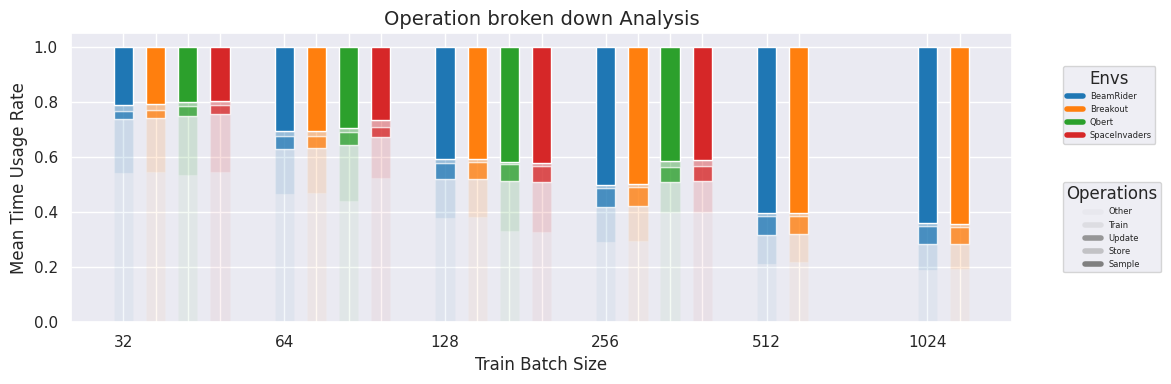

In [25]:
data = pd.concat([i[1].copy() for i in sampler.items()])
# Recompute necessary columns and groupings
data["store_relative"] = data["store"] / data["time_total_s"]
data["sample_relative"] = data["sample"] / data["time_total_s"]
data["train_relative"] = data["train"] / data["time_total_s"]
data["update_relative"] = data["update"] / data["time_total_s"]
data["all_relative"] = data["all"] / data["time_total_s"]
data["other_relative"] = data["all_relative"] - (data["store_relative"] + data["sample_relative"] + data["train_relative"] + data["update_relative"])

mean_relative_times_with_other = data.groupby(['bz', 'env'])[['store_relative', 'sample_relative', 'train_relative', 'update_relative', 'other_relative']].mean().reset_index()

unique_bz = mean_relative_times_with_other['bz'].unique()
unique_env = mean_relative_times_with_other['env'].unique()

# Color mapping for environments
colors = plt.cm.tab10.colors
env_color_map = {env: colors[i % len(colors)] for i, env in enumerate(unique_env)}

# Levels for operations
levels = [0.05, 0.15, 0.8, 0.4, 1]

# Adjusted bar width
adjusted_bar_width = 0.6

# Set up the figure and axis
plt.figure(figsize=[12, 4])
ax = plt.gca()

custom_xticks = []
custom_xticklabels = []

for i, bz in enumerate(unique_bz):
    subset_bz = mean_relative_times_with_other[mean_relative_times_with_other['bz'] == bz]
    for j, (index, row) in enumerate(subset_bz.iterrows()):
        color = env_color_map[row['env']]
        pos = i * 5 + j  # Adjusted to space out the bz values
        custom_xticks.append(pos)
        custom_xticklabels.append(row['bz'] if j == 0 else "")
        
        bottom = 0
        for operation, alpha in zip(["other_relative", "train_relative", "update_relative", "store_relative", "sample_relative"], levels):
            ax.bar(pos, row[operation], width=adjusted_bar_width, color=color, alpha=alpha, bottom=bottom)
            bottom += row[operation]

ax.set_xticks(custom_xticks)
ax.set_xticklabels(custom_xticklabels)
ax.set_xlabel('Train Batch Size', fontsize=12)
ax.set_ylabel('Mean Time Usage Rate', fontsize=12)
ax.set_title('Operation broken down Analysis', fontsize=14)

env_legend_handles = [plt.Line2D([0], [0], color=env_color_map[env], lw=4) for env in unique_env]
operation_legend_handles = [plt.Line2D([0], [0], color='gray', alpha=alpha, lw=4) for alpha in levels]
legend_env = ax.legend(env_legend_handles, unique_env, title="Envs", bbox_to_anchor=(1.05, 0.9), loc='upper left', fontsize=6)
ax.add_artist(legend_env)
ax.legend(operation_legend_handles, ["Other", "Train", "Update", "Store", "Sample"], title="Operations", bbox_to_anchor=(1.05, 0.5), loc='upper left', fontsize=6)

plt.tight_layout()
plt.subplots_adjust(right=0.85)

plt.savefig("./images/motivation/operation_stack.png")
plt.show()

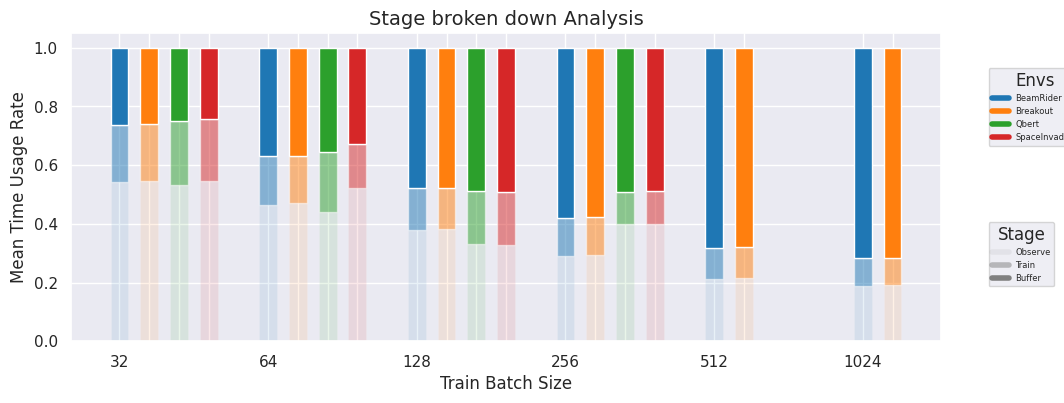

In [26]:
summary_image = pd.concat([i[1].copy() for i in sampler.items()])

# Assuming you've loaded the data into summary_image
summary_image["store_relative"] = summary_image["store"] / summary_image["time_total_s"]
summary_image["sample_relative"] = summary_image["sample"] / summary_image["time_total_s"]
summary_image["train_relative"] = summary_image["train"] / summary_image["time_total_s"]
summary_image["update_relative"] = summary_image["update"] / summary_image["time_total_s"]
summary_image["all_relative"] = summary_image["all"] / summary_image["time_total_s"]
summary_image["observe_relative"] = summary_image["all_relative"] - (summary_image["store_relative"] + summary_image["sample_relative"] + summary_image["train_relative"] + summary_image["update_relative"])
summary_image["buffer_relative"] = (summary_image["store_relative"] + summary_image["sample_relative"] + summary_image["update_relative"])

mean_relative_times_with_observe = summary_image.groupby(['bz', 'env'])[['store_relative', 'sample_relative', 'train_relative', 'update_relative', 'observe_relative', 'buffer_relative']].mean().reset_index()

unique_bz = mean_relative_times_with_observe['bz'].unique()
unique_env = mean_relative_times_with_observe['env'].unique()

# Color mapping for environments
colors = plt.cm.tab10.colors
env_color_map = {env: colors[i % len(colors)] for i, env in enumerate(unique_env)}

# Levels for operations
levels = [0.1, 0.5, 1]

# Adjusted bar width
adjusted_bar_width = 0.6

# Plotting
plt.figure(figsize=[12, 4])
ax = plt.gca()

custom_xticks_stage = []
custom_xticklabels_stage = []

for i, bz in enumerate(unique_bz):
    subset_bz = mean_relative_times_with_observe[mean_relative_times_with_observe['bz'] == bz]
    for j, (index, row) in enumerate(subset_bz.iterrows()):
        color = env_color_map[row['env']]
        pos = i * 5 + j
        custom_xticks_stage.append(pos)
        custom_xticklabels_stage.append(row['bz'] if j == 0 else "")
        
        bottom = 0
        for operation, alpha in zip(["observe_relative", "train_relative", "buffer_relative"], levels):
            ax.bar(pos, row[operation], width=adjusted_bar_width, color=color, alpha=alpha, bottom=bottom)
            bottom += row[operation]

ax.set_xticks(custom_xticks_stage)
ax.set_xticklabels(custom_xticklabels_stage)
ax.set_xlabel('Train Batch Size', fontsize=12)
ax.set_ylabel('Mean Time Usage Rate', fontsize=12)
ax.set_title('Stage broken down Analysis', fontsize=14)

env_legend_handles = [plt.Line2D([0], [0], color=env_color_map[env], lw=4) for env in unique_env]
operation_legend_handles = [plt.Line2D([0], [0], color='gray', alpha=alpha, lw=4) for alpha in levels]
legend_env = ax.legend(env_legend_handles, unique_env, title="Envs", bbox_to_anchor=(1.05, 0.9), loc='upper left', fontsize=6)
ax.add_artist(legend_env)
ax.legend(operation_legend_handles, ["Observe", "Train", "Buffer"], title="Stage", bbox_to_anchor=(1.05, 0.4), loc='upper left', fontsize=6)

# Adjusting the layout
plt.subplots_adjust(right=0.85)

plt.savefig("./images/motivation/stage_stacks.png")
plt.show()

In [17]:
summary_image[["bz","buffer_relative"]].groupby("bz").mean().reset_index()

,bz,buffer_relative
0,32,0.251450
1,64,0.359501
2,128,0.485094
3,256,0.559652
4,512,0.651074
5,1024,0.670531
